In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV


plt.rcParams["figure.figsize"] = (20,10)

In [2]:

def read_file(p):
    full_p = os.path.sep.join([os.getcwd(),'EmoBank-master','corpus',p])
    return pd.read_csv(full_p, delimiter='\t', quoting=3)#.set_index('id')

df_writer = read_file("writer.tsv")
df_reader = read_file("reader.tsv")
df_raw = read_file("raw.tsv")
df_meta = read_file("meta.tsv")
df_full = df_meta.merge(df_raw, on='id', suffixes=['_meta','_raw']).merge(df_writer, on='id', suffixes=['','_writer']).merge(df_reader, on='id', suffixes=['_writer','_reader']) 


In [3]:
print('writer: %d, reader: %d, raw: %d, meta: %d'%(df_writer.shape[0], df_reader.shape[0], df_raw.shape[0], df_meta.shape[0]))
print('joined data: %d'%df_full.shape[0])

writer: 10279, reader: 10325, raw: 10548, meta: 10548
joined data: 10062


In [4]:
rename_cols_dict = dict([('_'.join([a,b]),'_'.join([b,a.lower()])) for a,b in [s.split('_') for s in df_full.columns if '_' in s]])

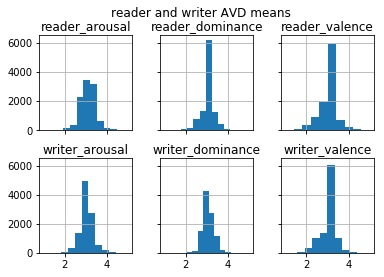

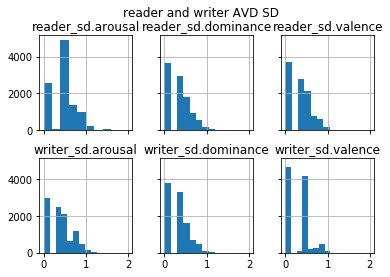

Index(['id', 'document', 'category', 'subcategory', 'sentence',
       'writer_arousal', 'writer_dominance', 'writer_valence',
       'writer_sd.arousal', 'writer_sd.dominance', 'writer_sd.valence',
       'writer_freq', 'reader_arousal', 'reader_dominance', 'reader_valence',
       'reader_sd.arousal', 'reader_sd.dominance', 'reader_sd.valence',
       'reader_freq'],
      dtype='object')


In [5]:
# lets understand how each target value behaves

df_full = df_full.rename(columns=rename_cols_dict)

df_full[[c for c in df_full.columns if ('sd' not in c and 'freq' not in c)]].hist(layout=(-1,3), sharex=True, sharey=True, bins=10)
plt.suptitle('reader and writer AVD means')
df_full[[c for c in df_full.columns if ('sd' in c)]].hist(layout=(-1,3), sharex=True, sharey=True, bins=10)
plt.suptitle('reader and writer AVD SD')
plt.show()
print(df_full.columns)

In [6]:
import spacy
# !python -m spacy download en
nlp = spacy.load(r'C:\Users\orc\Anaconda2\envs\intro2ml\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0'.replace('\\',os.path.sep))
df_full['spacy_doc'] = df_full.sentence.apply(lambda s: nlp(s))

In [7]:
# perform different text preprocessing

import string

sentence_to_lemmas = lambda doc: [token.lemma_ for token in doc if not (token.is_stop or (token.lemma_ in string.punctuation) or (token.lemma_ == '-PRON-'))]  
sentence_to_pos = lambda doc: [token.pos_ for token in doc]
sentence_to_text = lambda doc: [token.text for token in doc]
sentence_to_lowercase = lambda doc: [token.orth_.lower() for token in doc]

df_full['lemma_list'] = df_full.spacy_doc.apply(sentence_to_lemmas)
df_full['pos_list'] = df_full.spacy_doc.apply(sentence_to_pos)
df_full['text_list'] = df_full.spacy_doc.apply(sentence_to_text)
df_full['text_lower_list'] = df_full.spacy_doc.apply(sentence_to_lowercase) 
# didn't reconstruct ents_count column

In [8]:
# train-test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_full, random_state = 0)


In [9]:
# check total data and splits 
reader_sts = pd.DataFrame([df_full.std(), train.std(), test.std()])[['reader_valence','reader_arousal','reader_dominance']]
reader_sts.index = ['all data','train set','test set']
reader_sts


,reader_valence,reader_arousal,reader_dominance
all data,0.426694,0.328904,0.285328
train set,0.427994,0.331061,0.284379
test set,0.422827,0.322214,0.288070


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, _document_frequency
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

target_col = 'reader_valence'


def get_mse(regressor, X_train, y_train, X_test, y_test):
    train_mse = mean_squared_error(y_train, regressor.predict(X_train))
    test_mse = mean_squared_error(y_test, regressor.predict(X_test))
    return train_mse, test_mse

def grid_search(param_col, train, test, target_col, pipeline, parameters, save_prefix, cv=5):
    t0 = time()
    grid_search = GridSearchCV(pipeline, parameters, cv=cv, refit=True,
                               n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
    print("Performing grid search with %s"%param_col)
    grid_search.fit(train[param_col], train[target_col])
    print("done in %d seconds" % (time() - t0))
    print("Best parameters set:")
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, grid_search.best_estimator_.get_params()[param_name]))
    print("Best model train score: %0.3f" % mean_squared_error(grid_search.best_estimator_.predict(train[param_col]), train[target_col]))
    test_score = mean_squared_error(grid_search.best_estimator_.predict(test[param_col]), test[target_col])
    print("Best model test score: %0.3f" % test_score)
    joblib.dump(grid_search, '%s_%s_grid_search%0.3f.pkl'% (save_prefix,param_col,test_score), compress = 1)    
    return grid_search

def merge_dicts(a, b):
    merge = {}
    for k in a.keys():
        merge[k] = set(np.array([np.array([a[k]]).flatten(),(np.array([b[k]]).flatten())]).flatten())
    return merge

def model_summary(model, grid_params, param_col):
    model_details = dict([(k,v) for (k,v) in model.get_params().items() if k in grid_params])
    model_details['preprocessing'] = param_col
    train_score = mean_squared_error(model.predict(train[param_col]), train[target_col])
    test_score = mean_squared_error(model.predict(test[param_col]), test[target_col])
    model_details['train_score'] = train_score
    model_details['test_score'] = test_score
    return model_details

def models_comparator(grid_search_result, preprocs, grid_params):
    models_comparison = []
    for preproc in preprocs:
        best_model = grid_search_result[preproc.replace('_list','')].best_estimator_
        model_details = model_summary(best_model, grid_params, preproc)
        models_comparison.append(model_details)
    return pd.DataFrame(models_comparison)

def dummy_fun(doc):    
     return doc


In [10]:
tf_ifd_pipeline = Pipeline(
    [('vect', CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, min_df=1, 
              ngram_range=(1, 1), preprocessor=None, stop_words=None, strip_accents=False)),
     ('tfidf', TfidfTransformer(smooth_idf=True)),
     ('rgs', SVR(kernel='rbf', verbose=False))
    ])

tf_idf_params_grid = {'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'tfidf__use_idf': (True, False),
 'tfidf__norm': ('l1', 'l2'),
 'rgs__gamma': ('auto', 'scale'),
 'rgs__C': (0.5, 1, 100)}
  
tf_idf_grid_search = {}
if os.path.exists('tfidf_grid_search_all.pkl'):    
    tf_idf_grid_search = joblib.load('tfidf_grid_search_all.pkl')
    print('Done loading tf_idf grid search from file')
else:
    for param_col in ['lemma_list', 'pos_list','text_list', 'text_lower_list']:
        tf_idf_grid_search[param_col.replace('_list','')] = grid_search(param_col, train[:20], test[:20], target_col, tf_ifd_pipeline, tf_idf_params_grid, 'tfidf_new', cv=5)
    joblib.dump(tf_idf_grid_search, 'tfidf_grid_search_all.pkl', compress = 1)
    print('Done performing tf_idf grid search')

# create a df comparing best models for each preproc
tf_idf_grid_params = ['rgs__C', 'rgs__gamma', 'tfidf__norm', 
                      'tfidf__use_idf', 'vect__max_df', 'vect__max_features', 'vect__ngram_range']
preprocs = ['lemma_list', 'pos_list', 'text_list', 'text_lower_list']


tf_idf_model_comparison = models_comparator(tf_idf_grid_search, preprocs, tf_idf_grid_params)

print('''
Select the best preprocessing method. Excpet for the pos, which yielded worst score on both train and test,
all other preprocessings grid searchd found the optimal solution with the same hyper parameters. This makes the selection
in the lemmatizing preprocessing even more concrete as the optiomal solution.
''')
tf_idf_model_comparison[['preprocessing', 'test_score', 'train_score','rgs__C', 'rgs__gamma', 'tfidf__norm',
       'tfidf__use_idf', 'vect__max_df', 'vect__max_features', 'vect__ngram_range']]

Done loading tf_idf grid search from file

Select the best preprocessing method. Excpet for the pos, which yielded worst score on both train and test,
all other preprocessings grid searchd found the optimal solution with the same hyper parameters. This makes the selection
in the lemmatizing preprocessing even more concrete as the optiomal solution.



,preprocessing,test_score,train_score,rgs__C,rgs__gamma,tfidf__norm,tfidf__use_idf,vect__max_df,vect__max_features,vect__ngram_range
0,lemma_list,0.138323,0.018826,100,scale,l2,True,0.50,None,"(1, 2)"
1,pos_list,0.169265,0.171063,1,scale,l2,False,0.75,None,"(1, 2)"
2,text_list,0.139707,0.023333,100,scale,l2,True,0.50,None,"(1, 2)"
3,text_lower_list,0.137354,0.022278,100,scale,l2,True,0.50,None,"(1, 2)"


In [56]:
pd.DataFrame([tf_idf_params_grid,])

,rgs__C,rgs__gamma,tfidf__norm,tfidf__use_idf,vect__max_df,vect__max_features,vect__ngram_range
0,"(0.5, 1, 100)","(auto, scale)","(l1, l2)","(True, False)","(0.5, 0.75, 1.0)","(None, 5000, 10000)","((1, 1), (1, 2))"


In [11]:
''' Get a grid search result dict (with preprocs as keys) and return a DataFrame with params and mean test results'''
def grid_search_results_to_df(grid_search_result_dict, preprocs = ['lemma_list']):
    grid_search_results_df = None
    for preproc in preprocs:
        res = pd.DataFrame(grid_search_result_dict[preproc.replace('_list','')].cv_results_['params'])
        res['mean_test_score'] = -1 * grid_search_result_dict[preproc.replace('_list','')].cv_results_['mean_test_score']
        res['preprocessing'] = preproc
        if grid_search_results_df is None:
            grid_search_results_df = res
        else:
            grid_search_results_df = grid_search_comparator.append(res)
    return grid_search_results_df

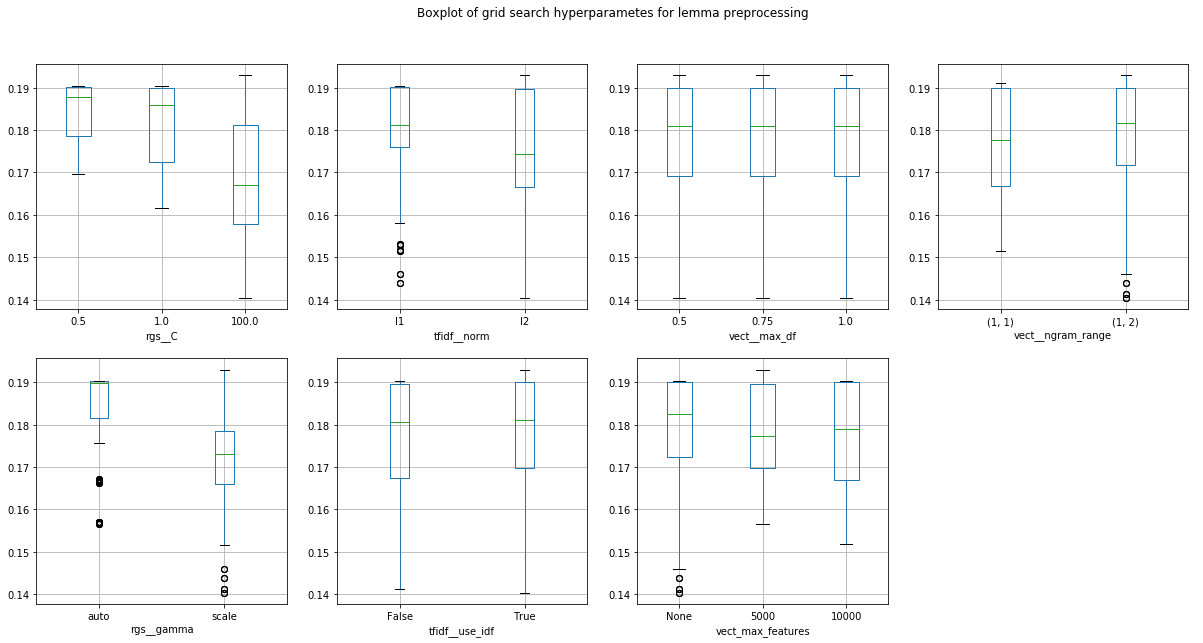


We will try to interpret the hyper paramaters effect on the grid search mean test scores. 
Below are boxplots of the different hyper parameters for the 'lemma' preprocessing. The values are the average 
mse of the 5 different CV done by the grid search. since it is the mse (and not the negative version of it), 
the lower the score - the better it is.
Note that hyper parameters might interact with each other - for instance, "use_idf" hyperparam might depened 
on the "ngram_range" hyperparam, since the vocabulary changes with different ngram range. Thus, these plots can 
only be used for genral notion and should be used carefully.

rgs_C - this is the SVM regressor's regularization coefficient, which gives better scores as the 
coefficient is higher - this means that our data is quite sparse and might be overfitted easily (especially 
with the used RBF kernel) - yielding higher mse; The high C value keeps the models from over fitting.
tfidf_norm - although l2 might appear better, we not

In [54]:
tf_idf_grid_search_results_df = grid_search_results_to_df(tf_idf_grid_search)
# fix None values of max_features so it gets plotted
tf_idf_grid_search_results_df['vect_max_features'] = tf_idf_grid_search_results_df.vect__max_features.apply(lambda x:x if x==x else 0.0)
param_for_plotting = ['rgs__C', 'rgs__gamma', 'tfidf__norm', 'tfidf__use_idf', 'vect__max_df',
       'vect_max_features', 'vect__ngram_range']
fig, axes = plt.subplots(2,4, figsize = (20,10))
for idx, param in enumerate(param_for_plotting):
    ax = axes[idx%2, int(idx/2)]
    tf_idf_grid_search_results_df.boxplot(column='mean_test_score', by=param, ax=ax)
    ax.set_title('')
axes[-1,-1].axis('off')
axes[-1,-2].set_xticklabels(['None','5000','10000'])
plt.suptitle('Boxplot of grid search hyperparametes for lemma preprocessing')
plt.show()

print(
'''
We will try to interpret the hyper paramaters effect on the grid search mean test scores. 
Below are boxplots of the different hyper parameters for the 'lemma' preprocessing. The values are the average 
mse of the 5 different CV done by the grid search. since it is the mse (and not the negative version of it), 
the lower the score - the better it is.
Note that hyper parameters might interact with each other - for instance, "use_idf" hyperparam might depened 
on the "ngram_range" hyperparam, since the vocabulary changes with different ngram range. Thus, these plots can 
only be used for genral notion and should be used carefully.

rgs_C - this is the SVM regressor's regularization coefficient, which gives better scores as the 
coefficient is higher - this means that our data is quite sparse and might be overfitted easily (especially 
with the used RBF kernel) - yielding higher mse; The high C value keeps the models from over fitting.
tfidf_norm - although l2 might appear better, we note that the outliers in l1 are centered in the lower range
of the score, meaning the distribution of l1 might not be very different than l2, this we cannot choose a 
preferred value.

vect_max_df and use_idf distribution seems to be quite similar, which might suggest it doesn't effect the 
results significantly.

vect__ngram_range - This is the ngram range to be used. Although it's median is slightly higher, we note that 
(1,2) range has outliers which are lower than (1,1) minimal value - meaning in some hyperparamaters subsets 
(including the best one found) (1,2) gives the lowest results. Since the (1,2) includes within it the (1,1) 
results, it actually adds information ontop of the (1,1)setup, information that might represent the sentence 
more accurately (such as coding names of places mentioned in the texts, simetimes composed of 2 words).

A word about normalization - We note that RBF-kernel SVR is a distance-based regression algorithm. This means 
that regression values depends directly on the distance of the sample from the support vectors (which themseleves 
depend on distances when these are selected). In such cases, it is crucial to scale the features to be on the 
same scale, otherwise we risk in making a specific feature over-dominant (feature with a relatively large value 
range, and few samples with near-zero values) or falsely-ignored ( features with relatively small range). The 
TfidfTransformer used in the pipeline performs l2 normalization (as a default behavior) on its output, whether or 
not IDF was performed on the CountVectorizer BOW output.

'''
)

In [58]:
# drill down into max_df
import numpy as np
count_vectorizer = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, max_df=1.0, max_features=None, min_df=1, 
              ngram_range=(1, 2), preprocessor=None, stop_words=None, strip_accents=False, binary=True)
count_vectorizer.fit(train.lemma_list)

max_word = count_vectorizer.get_feature_names()[count_vectorizer.transform(train.lemma_list).sum(axis=0).argmax()]
max_word_count = count_vectorizer.transform(train.lemma_list).sum(axis=0).max()

print(
'''We try to explain the simialr distributions of the max_df hyperparameter. This hyperparameter sets the max portion of 
document frequency ngram may have - any higher value will result with ignoring the ngram. 
And indeed, the word with the maximal document frequency is %s, with document frequency of %d, which is only %%%.f of the 
sentences, meaning none of the max_df values used in the grid search had any effect on the fitting, making this 
hyperparmeter useless to fit on.
'''%(max_word,max_word_count,100*max_word_count/train.shape[0])
)

We try to explain the simialr distributions of the max_df hyperparameter. This hyperparameter sets the max portion of 
document frequency ngram may have - any higher value will result with ignoring the ngram. 
And indeed, the word with the maximal document frequency is the, with document frequency of 701, which is only %9 of the 
sentences, meaning none of the max_df values used in the grid search had any effect on the fitting, making this 
hyperparmeter useless to fit on.



We try to explain the little effect the use_df hyperparameter has. This hyperparameter sets whether or not to 
perform idf multiplication of the term frequency in each sentence. The little effect this hyperparameter has can 
be explained by the fact that the df distribution is so assymetric, with the high values representing the lemmas
with only little appearances. The transformation uses sets the inverse df values to be log((n_samples+1) / (df+1) + 1),
meaning the more frequent the lemmas (very few such lemmas, as we just showed the most frequent one appears in less
than 10% for the sentences), the lower the idf value would be.
If the vast majority of words are normalized by the same value (and many more by a value smaller only be little),
we can expect the effect to be small, and mainly effect the more frequent valeus and their interaction with the rare 
lemms.



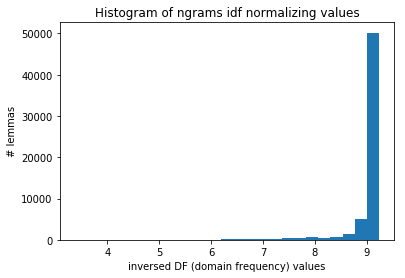

(60599,)

In [14]:
# drill down into use_idf
count_vectorizer = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, max_df=1.0, max_features=None, min_df=1, 
              ngram_range=(1, 2), preprocessor=None, stop_words=None, strip_accents=False)
count_vectorizer.fit(train.lemma_list)

tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tf_idf_transformer.fit(count_vectorizer.transform(train.lemma_list))

print(
'''We try to explain the little effect the use_df hyperparameter has. This hyperparameter sets whether or not to 
perform idf multiplication of the term frequency in each sentence. The little effect this hyperparameter has can 
be explained by the fact that the df distribution is so assymetric, with the high values representing the lemmas
with only little appearances. The transformation uses sets the inverse df values to be log((n_samples+1) / (df+1) + 1),
meaning the more frequent the lemmas (very few such lemmas, as we just showed the most frequent one appears in less
than 10% for the sentences), the lower the idf value would be.
If the vast majority of words are normalized by the same value (and many more by a value smaller only be little),
we can expect the effect to be small, and mainly effect the more frequent valeus and their interaction with the rare 
lemms.
''')
plt.hist(tf_idf_transformer._idf_diag.diagonal(), bins=25)
plt.title('Histogram of ngrams idf normalizing values')
plt.xlabel('inversed DF (domain frequency) values')
plt.ylabel('# lemmas')
plt.show()
tf_idf_transformer._idf_diag.max()

tf_idf_transformer._idf_diag.diagonal().shape

 Since the corpus is relatively small, we need to verify that we are able to encode the test set with the tf(-idf) encoding
produced by the fitting the train set. If the two sets doesn't share mostly the same words, we might end up with coding vast
moajority of the test set with zero-vectors. This is due to the fact that the BOW representation of a sentence made of word 
unfaimliar to the CountVectorizer is the zero-vector; This will yield the same prediction for all such vectors by the 
following regressor models.
To check this we can calculate the 'coverage' of each sentence in the test set - percentage of it's lemmas that exist in the 
vocabulary, built based on the lemmas in the train set. We can observe that most of the words (all but 8) has some words in 
it that exist in the tf-idf vocabulary built with the train set.



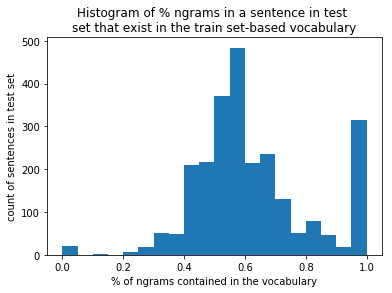

In [15]:
print(''' Since the corpus is relatively small, we need to verify that we are able to encode the test set with the tf(-idf) encoding
produced by the fitting the train set. If the two sets doesn't share mostly the same words, we might end up with coding vast
moajority of the test set with zero-vectors. This is due to the fact that the BOW representation of a sentence made of word 
unfaimliar to the CountVectorizer is the zero-vector; This will yield the same prediction for all such vectors by the 
following regressor models.
To check this we can calculate the 'coverage' of each sentence in the test set - percentage of it's lemmas that exist in the 
vocabulary, built based on the lemmas in the train set. We can observe that most of the words (all but 8) has some words in 
it that exist in the tf-idf vocabulary built with the train set.
'''
     )
plt.hist(list(np.asarray(count_vectorizer.transform(test.lemma_list).sum(axis=1)).reshape(-1) / 
    test.lemma_list.apply(lambda x:2*len(x)-1)), bins=20)
plt.title('Histogram of % ngrams in a sentence in test \nset that exist in the train set-based vocabulary')
plt.xlabel('% of ngrams contained in the vocabulary')
plt.ylabel('count of sentences in test set')
plt.show()


# W2V


In [16]:
import gensim 


class Word2VecTransformer(object):
    def __init__(self, min_count=None, size=50, window=3, iter=5):
        self.min_count = min_count
        self.size = size
        self.window = window
        self.iter = iter
    
    def set_params(self, min_count, size, window, iter):
        self.min_count = min_count
        self.size = size
        self.window = window
        self.iter = iter
    
    def fit(self, X, y):
        self.model = gensim.models.Word2Vec(
        X,
        size=self.size,
        window=self.window,
        min_count=self.min_count,
        iter=self.iter)
        return self
    
    def transform(self, X):
        res = []
        for sen in X:
            w_in_wv_map = [w for w in sen if w in self.model.wv]
            if len(w_in_wv_map) > 0:
                k = np.mean(np.array([self.model.wv[w] for w in w_in_wv_map]), axis=0)
            else:
                k = np.zeros(self.size)
            res.append(k)
        return np.array(res)
        
    def get_params(self, deep=True):
        return {'min_count':self.min_count, 'size':self.size, 'window':self.window, 'iter':self.iter}
        

C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [72]:
from time import time
from sklearn.model_selection import GridSearchCV

w2v_pipeline = Pipeline([('w2v',Word2VecTransformer()),
         ('rgs', SVR(kernel='rbf', verbose=False, gamma='scale'))])

w2v_params_grid = {'w2v__min_count': (1, 3, 5),
     'w2v__size': (50, 100, 300),
     'w2v__window': (3, 5, 7),
     'w2v__iter': (5, 10),
#      'rgs__gamma': ('scale',),
     'rgs__C': (10,100,500)}
  
w2v_grid_search = {}
preprocs = ['pos_list', 'text_list', 'text_lower_list']

if os.path.exists('w2v_grid_search_all.pkl'):    
    w2v_grid_search = joblib.load('w2v_grid_search_all.pkl')
    print('Done loading w2v grid search from file')
else:
    for param_col in preprocs:
        w2v_grid_search[param_col.replace('_list','')] = grid_search(param_col, train[:20], test[:20], target_col, w2v_pipeline, w2v_params_grid, 'w2v', cv=5)
    joblib.dump(w2v_grid_search, 'w2v_grid_search_all.pkl', compress = 1)
    print('Done performing w2v grid search')

# create a df comparing best models for each preproc
w2v_grid_params = ['w2v__min_count','w2v__size','w2v__window','w2v__iter','rgs__gamma','rgs__C']
w2v_model_comparison = models_comparator(w2v_grid_search, preprocs, w2v_grid_params)

w2v_model_comparison[['preprocessing', 'test_score', 'train_score','w2v__min_count', 'w2v__size',
                      'w2v__window','w2v__iter','rgs__gamma','rgs__C']]

Done loading w2v grid search from file

Select the best preprocessing method. Excpet for the pos, which yielded significantly worst score on both train and test,
all other preprocessings grid searchd found the optimal solution with the same hyper parameters. This makes the selection
in the lemmatizing preprocessing even more concrete as the optiomal solution.



,preprocessing,test_score,train_score,w2v__min_count,w2v__size,w2v__window,w2v__iter,rgs__gamma,rgs__C
0,pos_list,0.196350,0.201557,5,300,5,10,scale,100
1,text_list,0.195540,0.201051,5,100,3,5,scale,10
2,text_lower_list,0.194673,0.200050,5,50,7,10,scale,10


In [68]:
pd.DataFrame([w2v_params_grid,])

,rgs__C,w2v__iter,w2v__min_count,w2v__size,w2v__window
0,"(10, 100, 500)","(5, 10)","(1, 3, 5)","(50, 100, 300)","(3, 5, 7)"


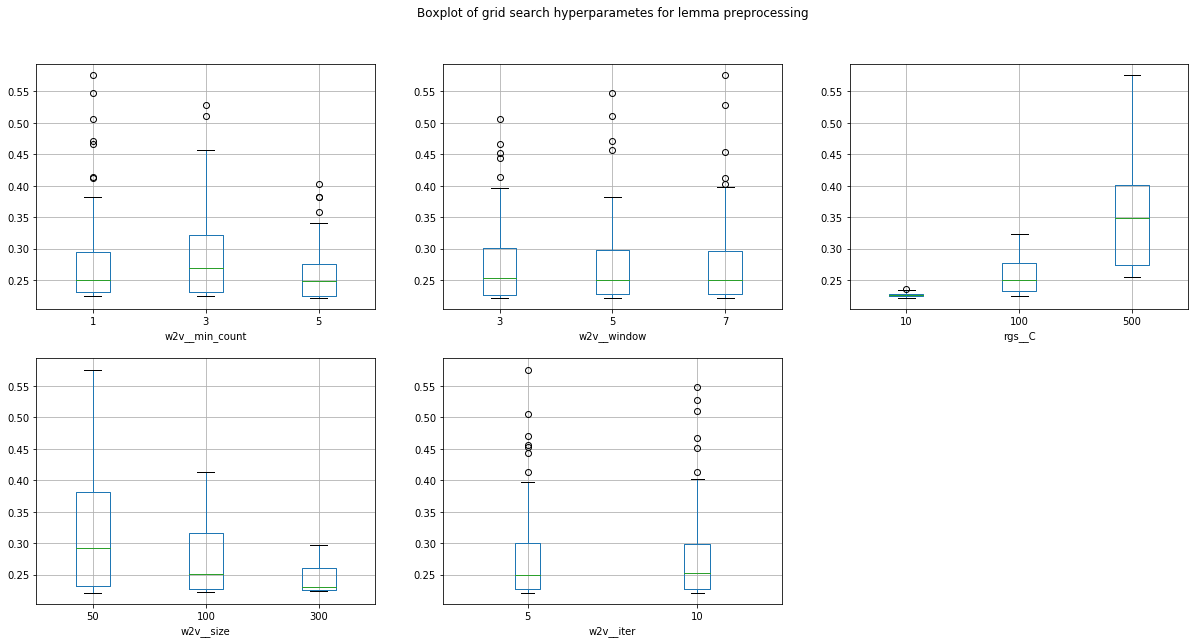

In [73]:
import pandas as pd
w2v_grid_search_results_df = grid_search_results_to_df(w2v_grid_search, preprocs=['text_lower_list'])

param_for_plotting = w2v_params_grid.keys()
fig, axes = plt.subplots(2,3)
for idx, param in enumerate(param_for_plotting):
    ax = axes[idx%2, int(idx/2)]
    w2v_grid_search_results_df.boxplot(column='mean_test_score', by=param, ax=ax)
    ax.set_title('')
axes[-1,-1].axis('off')
# axes[-1,-2].set_xticklabels(['None','5000','10000'])
plt.suptitle('Boxplot of grid search hyperparametes for lemma preprocessing')
plt.show()


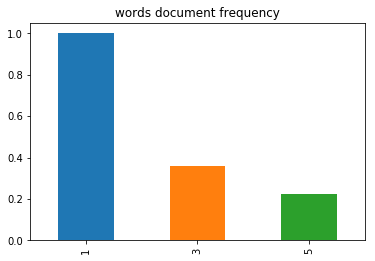

In [57]:
import numpy as np
words_counter_train_fit = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, min_df=1, 
              ngram_range=(1, 1), preprocessor=None, stop_words=None, strip_accents=False).fit_transform(train.text_lower_list)
counts = np.asarray(words_counter_train_fit.sum(axis=0)).reshape(-1)
def to_1_3_5(d):
    if d>=5: return 5
    if d>=3: return 3
    return 1
s = pd.Series([to_1_3_5(d) for d in counts])
vc = (s.value_counts()/len(s)).sort_index()
vc_cumsum = vc[::-1].cumsum()[::-1]
vc_cumsum.plot(kind='bar')
plt.title('words document frequency')
plt.show()

In [53]:
import gensim.downloader as api

w2v_model = api.load('word2vec-google-news-300')

1    1.000000
3    0.357834
5    0.223707
dtype: float64

In [20]:
# need to try embedding with this w2v


# Task-specific Encoding

In [21]:
'''Although corpus-statistics-based encoding is a common approach for such regression problem, since the specific 
VAD problem is well-researched, we can try leverage recent results in this task.
In his paper, Ahmad (https://saifmohammad.com/WebPages/nrc-vad.html) built a 20k words english vocabulary with 
annotated VAD values. We will address it as NRC-VAD dataset. We can use it's values to encode words of sentences in our dataset.
We address two design decisions when encoding:
1. Treating out-of-vocabulary words: 
Although it is the largest VAD annotated dataset published so of today, we can expect many words from our dataset to be missing 
from it. Instead of treating this problem with a common approach of the same "default" value returned for every missing word,
we will try to predict the missing word values. We will do this by utilizing a pretrained word2vec model in order to 
find the missing word K nearset neighbors, and assigning the missing word with a vlue based on it's neighbors annotation.
As a perliminary step, we will find the best K by doing a grid search.
2. Aggregating sentence's words encoding to a single vector:
This is a common problem when using encodings of varying-length element, such as word2vec of a sentence's words.
There are several approaches to this, like averaging  min\max-pool per dimension. Usually it is hard to give interpertation
as to why a specific method is better than the other - we will try to explain different results.'''

'Although corpus-statistics-based encoding is a common approach for such regression problem, since the specific \nVAD problem is well-researched, we can try leverage recent results in this task.\nIn his paper, Ahmad (https://saifmohammad.com/WebPages/nrc-vad.html) built a 20k words english vocabulary with \nannotated VAD values. We will address it as NRC-VAD dataset. We can use it\'s values to encode words of sentences in our dataset.\nWe address two design decisions when encoding:\n1. Treating out-of-vocabulary words: \nAlthough it is the largest VAD annotated dataset published so of today, we can expect many words from our dataset to be missing \nfrom it. Instead of treating this problem with a common approach of the same "default" value returned for every missing word,\nwe will try to predict the missing word values. We will do this by utilizing a pretrained word2vec model in order to \nfind the missing word K nearset neighbors, and assigning the missing word with a vlue based on it

## Treating out-of-vocabulary words


First, we would choose one preprocessing to focus on. We could do the whole process for every encoding (thus adding a 
'preprocessing' dimension to the grid search), but in this case we can apply some simple reasoning for selecting a spcific
encoding. Below are the elements (lemma \ word \ lower cased word) in our train set distribution over the 2 vocabularies -
the NRC from which we will get word encoding, and the w2v from which we will is vector space representation to estimate
NRC values of words missing from the NRC vocabulary. Our main goal is to choose a preprocessing that minimizes the words 
that don't have encoding at all, either direct from the NRC or estimated by KNN on w2v over NRC.
With this condition in mind, we will choose the simple text preprocessing, since it has 7% of words that do not appear in
NRC nor in the W2V vocab. The downside of this preprocessing is the fact that only 38% of the words are represented in the
NRC vocab, while the other preprocessings has 46% 

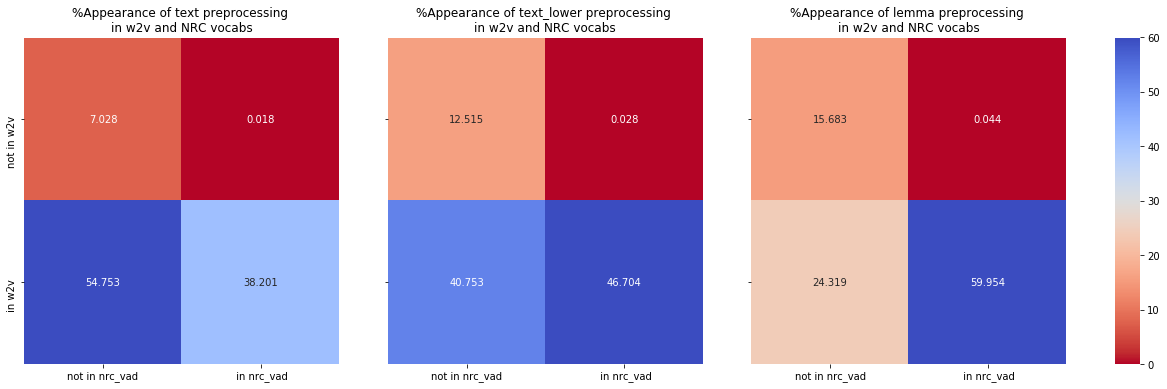

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

# load nrc scores into dict
nrc_vad_df = pd.read_csv(r'C:\Users\orc\Google Drive\MSc\ml_applications\NRC-VAD-Lexicon.txt', sep='\t')
nrc_vad = dict([(r.Word,{'v':r.Valence, 'a':r.Arousal, 'd':r.Dominance}) for i,r in nrc_vad_df.iterrows()])

# fig, axes = plt.subplots(1,3)
def counts_to_heatmap(vals, ax, title, cbar = False, cbar_ax=None):
    ll = set(itertools.chain(*vals))
    in_w2v_vocab = [int(l in w2v_model.vocab) for l in ll]
    in_nrc_vocab = [int(l in nrc_vad) for l in ll]
    cm = confusion_matrix(in_w2v_vocab, in_nrc_vocab) / len(ll) * 100
    g = sns.heatmap(cm, annot=True, ax = ax, cbar=cbar, cbar_ax=cbar_ax, fmt='.3f', cmap='coolwarm_r'); #annot=True to annotate cells
    g.set_ylabel('')
    g.set_xlabel('')
    # labels, title and ticks
    ax.set_title('%%Appearance of %s preprocessing \nin w2v and NRC vocabs'%title); 
    ax.set_xticklabels(['not in nrc_vad', ' in nrc_vad']); 
    return g

f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize = (20,6))

ax1.get_shared_y_axes().join(ax2,ax3)
g1 = counts_to_heatmap(train.text_list.values, ax1, 'text')
ax1.set_yticklabels(['not in w2v', 'in w2v']); 
g2 = counts_to_heatmap(train.text_lower_list.values, ax2, 'text_lower')
ax2.set_yticklabels(['', '']); 
g3 = counts_to_heatmap(train.lemma_list.values, ax3, 'lemma', cbar=True, cbar_ax=axcb)
ax3.set_yticklabels(['', '']); 

print('''
First, we would choose one preprocessing to focus on. We could do the whole process for every encoding (thus adding a 
'preprocessing' dimension to the grid search), but in this case we can apply some simple reasoning for selecting a spcific
encoding. Below are the elements (lemma \ word \ lower cased word) in our train set distribution over the 2 vocabularies -
the NRC from which we will get word encoding, and the w2v from which we will is vector space representation to estimate
NRC values of words missing from the NRC vocabulary. Our main goal is to choose a preprocessing that minimizes the words 
that don't have encoding at all, either direct from the NRC or estimated by KNN on w2v over NRC.
With this condition in mind, we will choose the simple text preprocessing, since it has 7% of words that do not appear in
NRC nor in the W2V vocab. The downside of this preprocessing is the fact that only 38% of the words are represented in the
NRC vocab, while the other preprocessings has 46% and 60% of the words in the NRC vocab, meaning in this selection we will
need to estimate more words with the KNN on w2v over NRC.
''')
plt.show()

In [23]:
import gensim.downloader as api
import itertools
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd


ll = set(itertools.chain(*train.text_list.values))

# wrap the w2v with a 
def get_from_model(w, m):
    if w in m.wv:
        return m.wv[w]
    else:
        return np.zeros(300)

# build vector representation lists of annotated and unannotated words
knn_X_labeled = np.array([get_from_model(l,w2v_model) for l in ll if (l in nrc_vad)])

def knn_grid_search_enricher(knn_X_labeled, knn_train_value, knn_params):
    knn_reg_model = KNeighborsRegressor() 
    grid_search = GridSearchCV(knn_reg_model, knn_params, cv=5, refit=True,
                              n_jobs=-1, verbose=1)
    return grid_search.fit(knn_X_labeled, knn_train_value)    

knn_params = {'n_neighbors' : [1,3,5,20, 50], 'weights': ['uniform','distance']}

if os.path.exists('knn_v_gridsearch_results.pkl'):    
    knn_v_gridsearch_results = joblib.load('knn_v_gridsearch_results.pkl')
    print('Done loading knn_v_gridsearch_results')
else:
    knn_train_value_v = [nrc_vad[l]['v'] for l in ll if l in nrc_vad]
    knn_v_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_v, knn_params)
    joblib.dump(knn_v_gridsearch_results, 'knn_v_gridsearch_results.pkl', compress = 1)

if os.path.exists('knn_a_gridsearch_results.pkl'):
    knn_a_gridsearch_results = joblib.load('knn_a_gridsearch_results.pkl')
    print('Done loading knn_a_gridsearch_results')
else:
    knn_train_value_a = [nrc_vad[l]['a'] for l in ll if l in nrc_vad]
    knn_a_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_a, knn_params)
    joblib.dump(knn_a_gridsearch_results, 'knn_a_gridsearch_results.pkl', compress = 1)

if os.path.exists('knn_d_gridsearch_results.pkl'):
    knn_d_gridsearch_results = joblib.load('knn_d_gridsearch_results.pkl')
    print('Done loading knn_d_gridsearch_results')
else:
    knn_train_value_d = [nrc_vad[l]['d'] for l in ll if l in nrc_vad]
    knn_d_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_d, knn_params)
    joblib.dump(knn_d_gridsearch_results, 'knn_d_gridsearch_results.pkl', compress = 1)


C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


Done loading knn_v_gridsearch_results
Done loading knn_a_gridsearch_results
Done loading knn_d_gridsearch_results


In [24]:
def get_enricher_df_summary(knn_x_enricher, vad_dimension):
    return pd.DataFrame([{'dimension':vad_dimension,'mean_test_score':score, 'std_test_score':std, 'n_neighbors': nei['n_neighbors'], 'weights': nei['weights']} for score,std,nei in list(zip(knn_x_enricher.cv_results_['mean_test_score'],knn_x_enricher.cv_results_['std_test_score'],knn_x_enricher.cv_results_['params']))])

v_best_params = knn_v_gridsearch_results.best_estimator_.get_params()
v_best_params['dimension']='Valence'
v_best_params['score'] = knn_v_gridsearch_results.best_score_
a_best_params = knn_a_gridsearch_results.best_estimator_.get_params()
a_best_params['dimension']='Arousal'
a_best_params['score'] = knn_a_gridsearch_results.best_score_
d_best_params = knn_d_gridsearch_results.best_estimator_.get_params()
d_best_params['dimension']='Dominance'
d_best_params['score'] = knn_d_gridsearch_results.best_score_

print(f'''In order to determine optimal KNN setup for a each dimesion, we performed a grid search over the following options:
{knn_params}
For each of the dimensions we got the following optimal hyperparameters; Note that unlike other scores addressed so far,
here the KNN estimatoin results is scored using R^2 score, thus we aim to maximize it, with 1 being the maximum value; The
fact that we get a value higher than 0 means we are doing better than the naive model of returning the average value,
meaning the assumption w2v idea of similarity between words express, amongs other things, a similarity in VAD characteristics
of words.
''')
pd.DataFrame([v_best_params, a_best_params, d_best_params])[['dimension','n_neighbors','weights','score']]

In order to determine optimal KNN setup for a each dimesion, we performed a grid search over the following options:
{'n_neighbors': [1, 3, 5, 20, 50], 'weights': ['uniform', 'distance']}
For each of the dimensions we got the following optimal hyperparameters; Note that unlike other scores addressed so far,
here the KNN estimatoin results is scored using R^2 score, thus we aim to maximize it, with 1 being the maximum value; The
fact that we get a value higher than 0 means we are doing better than the naive model of returning the average value,
meaning the assumption w2v idea of similarity between words express, amongs other things, a similarity in VAD characteristics
of words.



,dimension,n_neighbors,weights,score
0,Valence,5,distance,0.479848
1,Arousal,5,distance,0.325044
2,Dominance,20,distance,0.403666


In [25]:
# Create a dict that will assist encoding sentences using the NRC encoding, by estimating VAD values for words missing
# from NRC vocab

if os.path.exists('nrc_vad_est.pkl'):
    nrc_vad_est = joblib.load('nrc_vad_est.pkl')
    print('Done loading nrc_vad_est')
else:
    # # iterate over missing words and add their estimated values
    knn_X_not_labeled = np.array([get_from_model(l,w2v_model) for l in ll if (l not in nrc_vad)])
    missing_words = [l for l in ll if (l not in nrc_vad)]
    missing_v = knn_v_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)
    missing_a = knn_a_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)
    missing_d = knn_d_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)

    nrc_vad_est = dict([(w,{'v':v, 'a':a, 'd':d}) for w,v,a,d in zip(missing_words, missing_v, missing_a, missing_d)])
    nrc_vad_est.update(nrc_vad)
    # we build our dict based on the words in the training set; We still might encounter words in the test set that do not have
    # a mapping, since they didn't appear in the train set; Add these words to the nrc_vad_est

    ll_test = set(itertools.chain(*test.text_list.values))
    knn_X_not_labeled_test = np.array([get_from_model(l,w2v_model) for l in ll_test if (l not in nrc_vad_est)])
    missing_words_test = [l for l in ll_test if (l not in nrc_vad_est)]
    missing_v_test = knn_v_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    missing_a_test = knn_a_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    missing_d_test = knn_d_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    nrc_vad_est_test = dict([(w,{'v':v, 'a':a, 'd':d}) for w,v,a,d in zip(missing_words_test, missing_v_test, 
                                                                          missing_a_test, missing_d_test)])
    nrc_vad_est.update(nrc_vad_est_test)
    joblib.dump(nrc_vad_est, 'nrc_vad_est.pkl', compress = 1)


Done loading nrc_vad_est


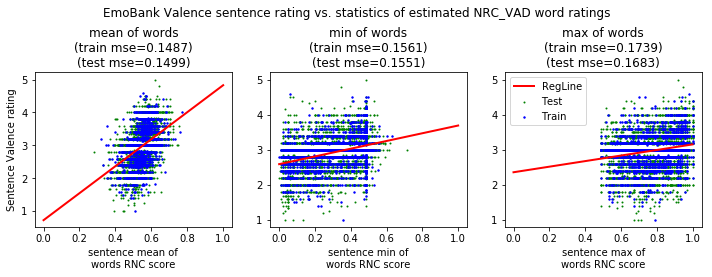

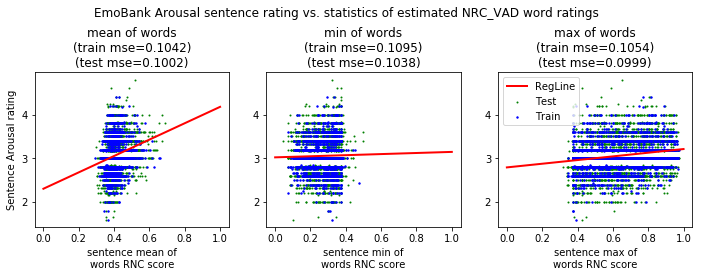

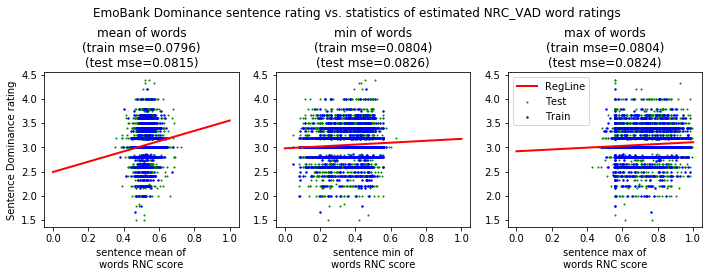

In [26]:
from sklearn import linear_model

# First we would try use the NRC values to directly preidct the 
def get_word_list_stats(word_list, nrc_vad_est, dimension):
    nrc_scores = [nrc_vad_est[w][dimension] for w in word_list]
    return {'mean':np.mean(nrc_scores), 'median':np.median(nrc_scores), 'min':np.min(nrc_scores), 'max':np.max(nrc_scores), 'std':np.std(nrc_scores)}


def plot_emo_vs_nrc_statistics(dimension, nrc_vad_est, train_reader_x, test_reader_x, dimension_full):
    fig, axes = plt.subplots(1,3,figsize=(10,4))
    X_train_all = train.text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, dimension)).values
    X_test_all = test.text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, dimension)).values
    for idx, stat in enumerate(['mean','min','max']):
        ax = axes[idx]
        X_train = np.array([x[stat] for x in X_train_all]).reshape(-1,1)
        X_test = np.array([x[stat] for x in X_test_all]).reshape(-1,1)
        ax.scatter(X_train, train_reader_x, s=1, c='g')
        ax.scatter(X_test, test_reader_x, s=2, c='b')
        ax.set_xlabel(f'sentence {stat} of\nwords RNC score')        
        model = linear_model.LinearRegression()
        model.fit(X_train, train_reader_x)
        y_pred =  model.predict([[0],[1]])
        train_mse = mean_squared_error(model.predict(X_train.reshape(-1, 1)), train_reader_x)
        test_mse = mean_squared_error(model.predict(X_test.reshape(-1, 1)), test_reader_x)
        ax.plot([0,1], y_pred, color='red', linewidth=2)
        ax.set_title('%s of words\n(train mse=%.4f)\n(test mse=%.4f)'%(stat, train_mse, test_mse))            
    axes[0].set_ylabel(f'Sentence {dimension_full} rating')
    axes[2].legend(['RegLine','Test','Train'])
    plt.suptitle(f'EmoBank {dimension_full} sentence rating vs. statistics of estimated NRC_VAD word ratings')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])



plot_emo_vs_nrc_statistics('v', nrc_vad_est, train.reader_valence, test.reader_valence, 'Valence')
plot_emo_vs_nrc_statistics('a', nrc_vad_est, train.reader_arousal, test.reader_arousal, 'Arousal')
plot_emo_vs_nrc_statistics('d', nrc_vad_est, train.reader_dominance, test.reader_dominance, 'Dominance')

In [37]:
'''We can treat all the statistics (mean, max, min, std) for every dimension as a list of features. We will try to use these
features with a 2 interpertable models - a simple decision tree (DT) and LightGBM'''

from sklearn.preprocessing import StandardScaler

# create features representation for text_list
def extract_nrc_stats(text_list):
    df_v = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'v')).tolist())
    df_v = df_v.rename(columns = dict([(c,'v_'+c) for c in df_v.columns]))
    df_a = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'a')).tolist())
    df_a = df_a.rename(columns = dict([(c,'a_'+c) for c in df_a.columns]))
    df_d = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'd')).tolist())
    df_d = df_d.rename(columns = dict([(c,'d_'+c) for c in df_d.columns]))
    df_train = pd.concat([df_v, df_a, df_d], axis=1)
    return df_train

train_nrc_stats = extract_nrc_stats(train.text_list)
scaler = StandardScaler()
train_nrc_stats_scaled = scaler.fit_transform(train_nrc_stats)
test_nrc_stats = extract_nrc_stats(test.text_list)
test_nrc_stats_scaled = scaler.fit(test_nrc_stats)

In [38]:
# train a decision tree, Adaboost and lgbm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rf_nrc_vad = DecisionTreeRegressor(max_depth=5).fit(train_nrc_stats, train[target_col])
adaboost_nrc_vad = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), n_estimators=50, 
                                     learning_rate=1.0, loss='linear', random_state=0).fit(train_nrc_stats, train[target_col])
params_grid = {'gamma': ('auto', 'scale'), 'C': (0.5, 1, 100)}
svm_nrc_vad_grid_search = GridSearchCV(SVR(kernel='rbf', verbose=False), params_grid, cv=5, refit=True,
                           n_jobs=-1, verbose=1, scoring='neg_mean_squared_error').fit(train_nrc_stats_scaled, train[target_col])
# svm_nrc_vad = SVR(kernel='rbf', verbose=False).fit(train_nrc_stats, train[target_col])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


In [29]:
def model_summary_DT(model, model_name, preds, params):
    model_details = dict([(k,v) for (k,v) in model.get_params().items() if k in params])
#     model_details = {}
    model_details['preprocessing'] = 'NRC_VAD_estimated_stats'
    model_details['train_score'] = mean_squared_error(preds, train[target_col])
    model_details['test_score'] = mean_squared_error(model.predict(test_nrc_stats), test[target_col])
    model_details['model'] = model_name
    return model_details
rf_summary = model_summary_DT(rf_nrc_vad, 'DecisionTree', adaboost_summary.predict(train_nrc_stats), ['max_depth'])
adaboost_summary = model_summary_DT(adaboost_nrc_vad, 'AdaBoost', adaboost_nrc_vad.predict(train_nrc_stats), [])
svm_summary = model_summary_DT(svm_nrc_vad_grid_search.best_estimator_, 'SVM', svm_nrc_vad_grid_search.predict(train_nrc_stats_scaled), ['gamma','C'])
pd.DataFrame([rf_summary, adaboost_summary, svm_summary])

,C,gamma,max_depth,model,preprocessing,test_score,train_score
0,NaN,NaN,5.0,DecisionTree,NRC_VAD_estimated_stats,0.143816,0.131686
1,NaN,NaN,NaN,AdaBoost,NRC_VAD_estimated_stats,0.138693,0.135012
2,100.0,scale,NaN,SVM,NRC_VAD_estimated_stats,0.136480,0.131880


 We can look into the simple decision tree we've trained, and examine the decisions it made. Observing a 
decision tree trained on the same data with max_depth=3 will give the same results, since the first 3 splits would 
be the same (since all splitting parameters are the same). 
We can see that the Valence-related values are the ones selected at each of the first 3 splits - and with great correlatoin
with the value of the leaves (if a value is higher than a selected cut-off of v-min/mean/max, it will end up in a leaf with
a higher value.
Note that the split criterion of the regression tree is mse, which is the metric we chose to work on, thus the fitted tree
is optimized according to our target.
We didn't apply any scaling to the generated encoding prior to sending them to the SVM model since they all come from 
the same range; A refining step would be to normalize prior to fitting with SVM, and using the same transformation for 
an future tests (in specific, with thte test ..



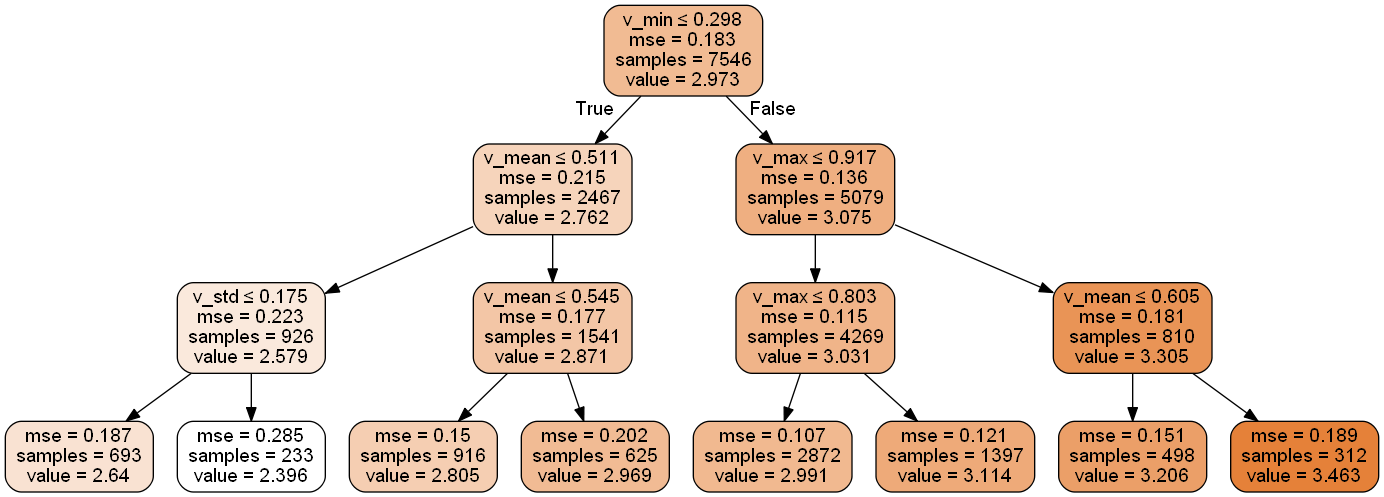

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import os
# add graphviz to path
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

rf_nrc_vad = DecisionTreeRegressor(max_depth=3)  
rf_nrc_vad.fit(train_nrc_stats, train[target_col])
dot_data = StringIO()
export_graphviz(rf_nrc_vad, out_file=dot_data,  
                feature_names = train_nrc_stats.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print(''' We can look into the simple decision tree we've trained, and examine the decisions it made. Observing a 
decision tree trained on the same data with max_depth=3 will give the same results, since the first 3 splits would 
be the same (since all splitting parameters are the same). 
We can see that the Valence-related values are the ones selected at each of the first 3 splits - and with great correlatoin
with the value of the leaves (if a value is higher than a selected cut-off of v-min/mean/max, it will end up in a leaf with
a higher value.
Note that the split criterion of the regression tree is mse, which is the metric we chose to work on, thus the fitted tree
is optimized according to our target.
We didn't apply any scaling to the generated encoding prior to sending them to the SVM model since they all come from 
the same range; A refining step would be to normalize prior to fitting with SVM, and using the same transformation for 
an future tests (in specific, with thte test ..
''')

Image(graph.create_png())

In [1984]:
# # path_writer_emotion
# # path_reader_emotion
# # path_raw
# # path_meta
# # os
# # sys
# # read_file
# # df_writer
# # df_reader
# # df_raw
# # df_meta
# # df_full
# # plt
# means_cols
# rename_cols
# rename_cols_dict
# spacy
# nlp
# doc
# token
# a
# string
# sentence_to_lemmas
# TfidfVectorizer
# v
# vv
# train_test_split
# train
# test
X
DecisionTreeRegressor
# mean_squared_error
# target_col
tree
X_train
X_test
# SVR
# get_mse
# svr_model
# tfidf_results
target_cols
naive_mse
train_mse
test_mse
train_target_mean
# CountVectorizer
# TfidfTransformer
GridSearchCV
Pipeline
# pipeline
parameters
# grid_search
pprint
# time
print_function
# logging
# t0
# best_parameters
param_name
# sentence_to_pos
# tfidf_grid_search
# pos_grid_search
# vectorizer
# counts
# vc
# joblib
# ret
# r2_score
lemmas_count
np
word_cardinality
scipy
stats
word_freq
unique
ratios
word_frequency
lem_list_lens
word_exist
p
rets
dummy_fun
cv
rough_percentiles
rp
merge_dicts
grid_search_params
i
grid_search_params_df
rgs
d
Word2Vec
model
word2vec
words
r
TransformerMixin
FeatureUnion
Word2VecTransformer
w2v_grid_search
w2vmodel
fitted
warnings
lemmas
res
PCA
clf
optimal_w2v_model
transformed_train
# sentence_to_tokens
# sentence_to_orth
test_score
tf_idf_param
axes
ax_idx
fix
ax
fig
# sentence_to_lowercase
# sentence_to_text
gridsearch
tf_idf_grid_search
nrc_vad
chain
best_model
preproc
model_details
preprocs
models_comparison
param_col
train_score
grid_params
model_summary
models_comparator
w2v_comparison
w2v_grid_params
tfidf_grid_params
tf_idf_grid_params
tf_idf_comparison
glove_model_name
api
info
nrc_vad_lemmas
missing_lemmas
lemmas_list
shared_lemmas
train_lemmas
nrc_vad_c
lemma_w2v_vad_mappings
lemma
lemma_w2v_missing_vad_mappings
knn_X
knn_train_v
knn_train_a
knn_train_d
KNeighborsRegressor
v_knnr
knn_X_labeled
knn_X_not_labeled
knn_labeled_v
knn_labeled_a
knn_labeled_d
knn_enricher
knn_not_labeled_v
knn_not_labeled_a
knn_not_labeled_d
knn_lemmas_labeled
knn_lemmas_not_labeled
defaultdict
est_nrc_v
get_lemma_to_nrc_score
lemma_to_nrc_v
lemma_to_nrc_a
lemma_to_nrc_d
get_lemmas_list_stats
pretrained_w2v_model_name
count_in_vocab
knn_grid_search_enricher
knn_v_enricher
get_enricher_df_summary
grid_search_knn_summary
results
knn_a_enricher
knn_d_enricher
idx
stat
dim
plot_emo_vs_nrc_statistics
linear_model
types
k
inspect
getsource
k_
name

In
Out
get_ipython
exit
quit
pd
path_writer_emotion
path_reader_emotion
path_raw
path_meta
os
sys
read_file
df_writer
df_reader
df_raw
df_meta
df_full
plt
means_cols
rename_cols
rename_cols_dict
spacy
nlp
doc
token
a
string
sentence_to_lemmas
TfidfVectorizer
v
vv
train_test_split
train
test
X
DecisionTreeRegressor
mean_squared_error
target_col
tree
X_train
X_test
SVR
get_mse
svr_model
tfidf_results
target_cols
naive_mse
train_mse
test_mse
train_target_mean
CountVectorizer
TfidfTransformer
GridSearchCV
Pipeline
pipeline
parameters
grid_search
pprint
time
print_function
logging
t0
best_parameters
param_name
sentence_to_pos
tfidf_grid_search
pos_grid_search
vectorizer
counts
vc
joblib
ret
r2_score
lemmas_count
np
word_cardinality
scipy
stats
word_freq
unique
ratios
word_frequency
lem_list_lens
word_exist
p
rets
dummy_fun
cv
rough_percentiles
rp
merge_dicts
grid_search_params
i
grid_search_params_df
rgs
d
Word2Vec
model
word2vec
words
r
TransformerMixin
FeatureUnion
Word2VecTransformer
w2v